# Linear Trends of ANHA4-EHX005 Variables

In [4]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [5]:
import glob
import datetime
import scipy.io
import scipy.signal
import numpy as np
import netCDF4 as nc
import cartopy.feature
import matplotlib.pyplot as plt
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [40]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [6]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

fake_x = np.arange(144)

In [7]:
def get_trend_ANHA4(T):
    T = T[:, 350:, :]
    T = Ats.seasonal_decomp3d(T)
    T[np.isnan(T)]=0
    ztrend_T = np.zeros([450, 544])
    for i in range(450):
        for j in range(544):
            ztrend_T[i, j], _ = np.polyfit(fake_x, T[:, i, j], 1)
    return ztrend_T

def get_trend_GDPS(T):
    T = Ats.seasonal_decomp3d(T)
    T[np.isnan(T)]=0
    ztrend_T = np.zeros([233, 801])
    for i in range(233):
        for j in range(801):
            ztrend_T[i, j], _ = np.polyfit(fake_x, T[:, i, j], 1)
    return ztrend_T

In [8]:
coordinate_name=glob.glob('../../_data/Exchange/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
coordinate_name=glob.glob('../../_data/Exchange/coordinates_ANHA4.nc')
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]

In [9]:
lev_ztrend_FWC = np.array([-9, -7, -5, -3, -1, 1, 3, 5, 7, 9])/200.0*12.0
lev_ztrend_emps = np.array([-9, -7, -5, -3, -1, 1, 3, 5, 7, 9])/2.0*12.0

# The linear trend of freshwater content (d<120m)

In [10]:
FWC_name = sorted(glob.glob('../../_data/MAT files/FWC/FWC_ANHA4_d23*.mat'))
FWC = np.zeros([144, 800, 544])

for i in range(144):
    MAT = scipy.io.loadmat(FWC_name[i])
    FWC[i, :, :] = MAT['FWC'][:]
ztrend_FWC = get_trend_ANHA4(FWC)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


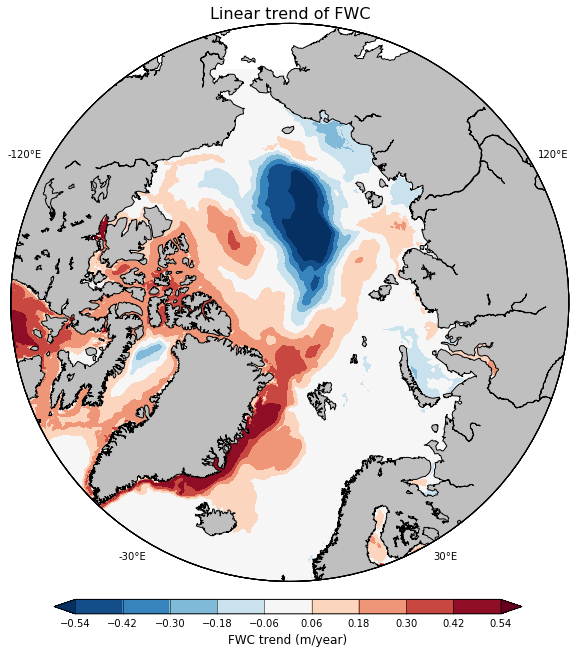

In [11]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.array([-120, -30, 30, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.75', lake_color=None)
proj.drawcoastlines(linewidth=1, color='k')
x, y = proj(nav_lon[350:, :], nav_lat[350:, :])
CS = proj.contourf(x, y, ztrend_FWC*12.0, lev_ztrend_FWC, cmap = plt.cm.RdBu_r, extend='both')

ax.set_title('Linear trend of FWC', fontsize=16)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('FWC trend (m/year)', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_ztrend_FWC)

## concentration/dilution flux

** Here use "-emps", which has positive for dilution and negative for concentration. **

In [12]:
safl_name = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/iocesafl_monmean.nc'
sss_name  = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
safl_obj = nc.Dataset(safl_name)
safl = safl_obj.variables['iocesafl'][:]
sss_obj = nc.Dataset(sss_name)
sss = sss_obj.variables['isssalin'][:]
emps=-1.0*safl*34.7/(3600.0*24*(sss+1.0e-16))
#
ztrend_emps = ztrend_FWC = get_trend_ANHA4(-emps)

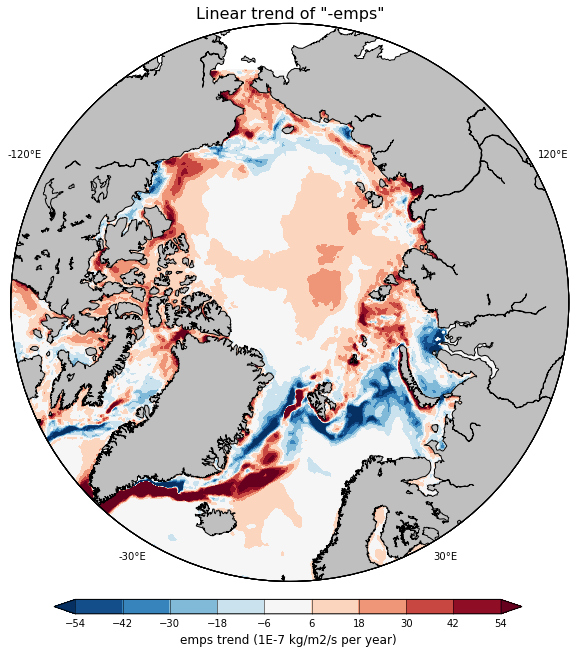

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.array([-120, -30, 30, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.75', lake_color=None)
proj.drawcoastlines(linewidth=1, color='k')
x, y = proj(nav_lon[350:, :], nav_lat[350:, :])
CS = proj.contourf(x, y, ztrend_emps*1e7*12.0, lev_ztrend_emps, cmap=plt.cm.RdBu_r, extend='both')

ax.set_title('Linear trend of "-emps"', fontsize=16)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('emps trend (1E-7 kg/m2/s per year)', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_ztrend_emps)

## SST

In [14]:
# ocean u/v
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current_new.mat')
vozocrtx0 = MAT['vozocrtx0'][:]
#vozocrtx1 = MAT['vozocrtx1'][:]
vomecrty0 = MAT['vomecrty0'][:]
#vomecrty1 = MAT['vomecrty1'][:]
# Sea-surface salinity
S_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isssalin_monmean.nc'
S_obj = nc.Dataset(S_FName)
S = S_obj.variables['isssalin'][:, :, :]
# SST
T_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/isstempe_monmean.nc'
T_obj = nc.Dataset(T_FName)
T = T_obj.variables['isstempe'][:, :, :]
T = Ats.seasonal_decomp3d(T)
# SSH
obj_h = nc.Dataset('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc')
ssh = obj_h.variables['sossheig'][:]
ssh[ssh>100] = np.nan

In [15]:
ztrend_T = ztrend_FWC = get_trend_ANHA4(T)

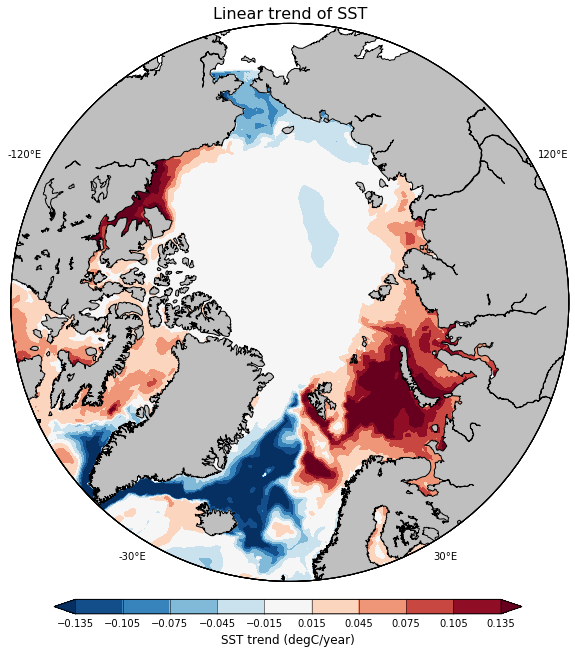

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.array([-120, -30, 30, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.75', lake_color=None)
proj.drawcoastlines(linewidth=1, color='k')
x, y = proj(nav_lon[350:, :], nav_lat[350:, :])
CS = proj.contourf(x, y, ztrend_T*12.0, lev_ztrend_FWC/4.0, cmap=plt.cm.RdBu_r, extend='both')

ax.set_title('Linear trend of SST', fontsize=16)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SST trend (degC/year)', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_ztrend_FWC/4.0)

## U/V

In [17]:
ztrend_U = get_trend_ANHA4(vozocrtx0)
ztrend_V = get_trend_ANHA4(vomecrty0)

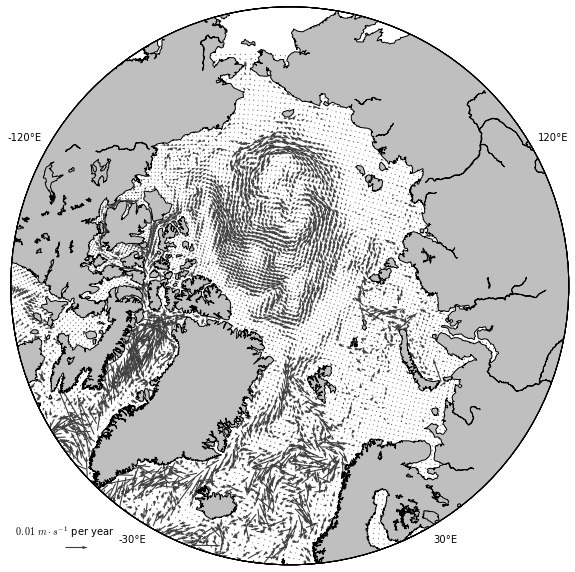

In [18]:
n = 4
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.array([-120, -30, 30, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.75', lake_color=None)
proj.drawcoastlines(linewidth=1, color='k')
x, y = proj(nav_lon[350:, :], nav_lat[350:, :])
Q = proj.quiver(x[::n, ::n], y[::n, ::n], ztrend_U[::n, ::n]*12.0, ztrend_V[::n, ::n]*12.0, 
    width=0.002, headwidth=3, scale=0.25, color='0.25')
qk = plt.quiverkey(Q, 0.2, 0.15, 0.01, r'$0.01\ m\cdot s^{-1}$ per year', coordinates='figure')

## SSH

In [19]:
ztrend_ssh = get_trend_ANHA4(ssh)

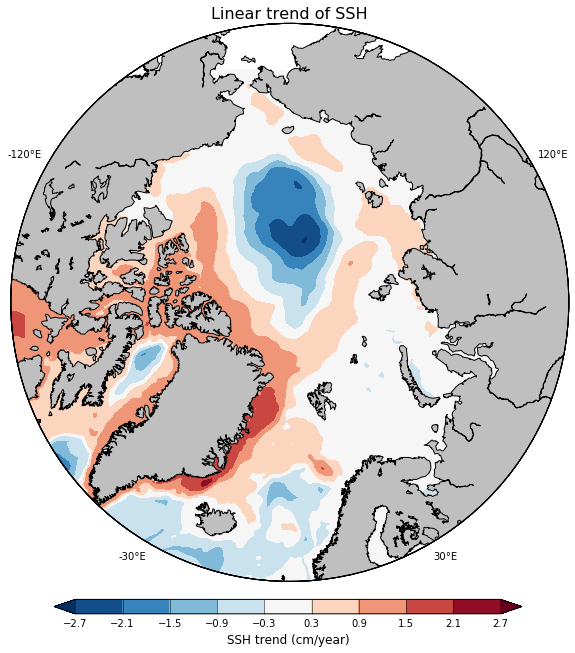

In [20]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.array([-120, -30, 30, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.75', lake_color=None)
proj.drawcoastlines(linewidth=1, color='k')
x, y = proj(nav_lon[350:, :], nav_lat[350:, :])
CS = proj.contourf(x, y, ztrend_ssh*12.0*100, lev_ztrend_FWC*5, cmap=plt.cm.RdBu_r, extend='both')

ax.set_title('Linear trend of SSH', fontsize=16)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SSH trend (cm/year)', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_ztrend_FWC*5)

In [21]:
year = np.arange(2002, 2014)
slp = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*slp*'+str(year[i])+'*monmean*')
    slp_obj = nc.Dataset(name[0])
    slp[i*12:(i+1)*12, :, :] = slp_obj.variables['atmpres'][:, :, :]
# GDPS-U10
u10 = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*u10*'+str(year[i])+'*monmean*')
    u10_obj = nc.Dataset(name[0])
    u10[i*12:(i+1)*12, :, :] = u10_obj.variables['u_wind'][:, :, :]
# GDPS-V10
v10 = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*v10*'+str(year[i])+'*monmean*')
    v10_obj = nc.Dataset(name[0])
    v10[i*12:(i+1)*12, :, :] = v10_obj.variables['v_wind'][:, :, :]
# GDPS-T2
t2 = np.empty([144, 368, 801])
for i in range(12):
    name = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*t2*'+str(year[i])+'*monmean*')
    t2_obj = nc.Dataset(name[0])
    t2[i*12:(i+1)*12, :, :] = t2_obj.variables['tair'][:, :, :]
# Lat/Lon corrd.    
x = slp_obj.variables['LON'][:]
y = slp_obj.variables['LAT'][:]
[slp_lon, slp_lat] = np.meshgrid(x, y)
slp_lon = slp_lon[y>20, :]
slp_lat = slp_lat[y>20, :]
# Cut Polar-ward 20degN
slp = slp[:, y>20, :]/100.0
u10 = u10[:, y>20, :]
v10 = v10[:, y>20, :]
t2 = t2[:, y>20, :]

In [29]:
ztrend_u = get_trend_GDPS(u10)
ztrend_v = get_trend_GDPS(v10)

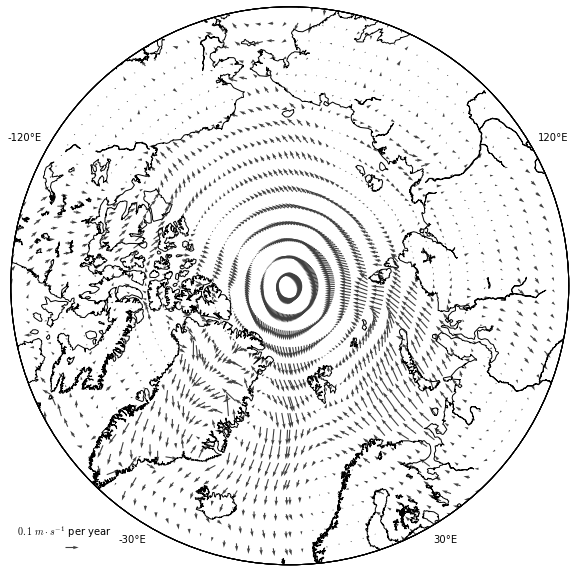

In [39]:
n = 6
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.array([-120, -30, 30, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color='0.75', lake_color=None)
proj.drawcoastlines(linewidth=1, color='k')
uproj, vproj, x, y = proj.rotate_vector(ztrend_u, ztrend_v, slp_lon, slp_lat, returnxy=True)
Q = proj.quiver(x[::n, ::n], y[::n, ::n], uproj[::n, ::n]*12.0, vproj[::n, ::n]*12.0, 
    width=0.002, headwidth=3, scale=4.25, color='0.25')
qk = plt.quiverkey(Q, 0.2, 0.15, 0.1, r'$0.1\ m\cdot s^{-1}$ per year', coordinates='figure')

In [24]:
ztrend_t2 = get_trend_GDPS(t2)

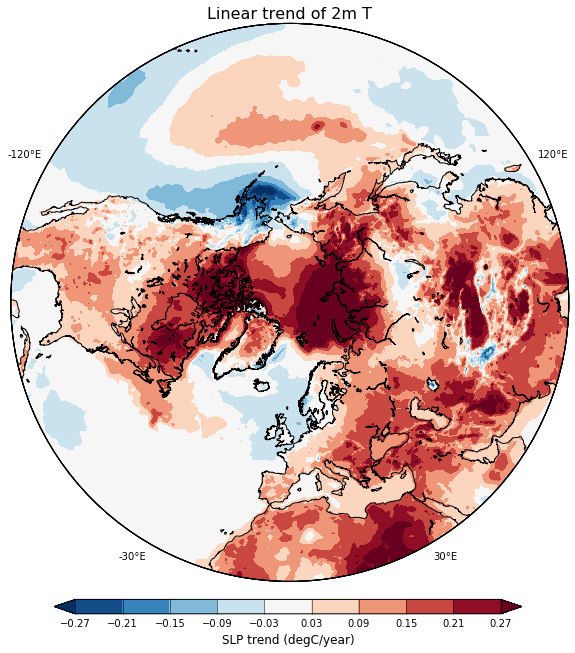

In [28]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.array([-120, -30, 30, 120]), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
#proj.fillcontinents(color='0.75', lake_color=None)
proj.drawcoastlines(linewidth=1, color='k')
x, y = proj(slp_lon, slp_lat)
CS = proj.contourf(x, y, ztrend_t2*12.0, lev_ztrend_FWC/2.0, cmap=plt.cm.RdBu_r, extend='both')

ax.set_title('Linear trend of 2m T', fontsize=16)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP trend (degC/year)', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_ztrend_FWC/2.0)

# Conclusion
* The positive trend of FWC in CAA and Baffin Bay is caused by the increasing sea-ice melt (emps, sst)
* The Negative FWC trend in Makarove Basin and its positive conterpart in Beaufort Gyre are caused by an increasingly strong cyclonic 10m wind pattern. 

In [1]:
#FName = '/ocean/yingkai/GEOTRACES/Simulations/BASE03_1m_20020101_20131231_ptrc_T.nc'
#ptrc_obj = nc.Dataset(FName)
#Ba = np.zeros([144, 800, 544])
#for i in range(23):
#    Ba += ptrc_obj.variables['Ba'][:, i, :, :]
#Ba[Ba==0]=np.nan
#Ba = Ba/23.0
#
#d18O = np.zeros([144, 800, 544])
#for i in range(23):
#    d18O += ptrc_obj.variables['d18O'][:, i, :, :]
#d18O[np.isnan(Ba)]=np.nan
#d18O = d18O/23.0

In [2]:
#save_var = { 'Ba'  : Ba,\
#             'd18O': d18O
#            }
#scipy.io.savemat('../../_data/MAT files/BASE03_120m_tracer_vals.mat', mdict=save_var)